In [51]:
# Input image, SD_HE_20x Overlay, Retrain Overlay
from my_utils import stardisting as sd

import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import measure
import os
from tqdm import tqdm

model_path = r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\StarDist Segmentation Models\SD_HE_20x"
img_folder = r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\20x Native\JHU\images"
gt_folder = r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\20x Native\JHU\masks"
output_folder = r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\StarDist Segmentation Models\Collage"
model = sd.load_model(model_path=model_path)

names, images, gts = [], [], []
img_names = os.listdir(img_folder)
for img_name in img_names:
    if img_name.endswith('.tif') and 'test' in img_name:
    # if 'Skin_test_3.tif' in img_name:
        names.append(img_name)
        images.append(io.imread(os.path.join(img_folder, img_name)))
        gts.append(io.imread(os.path.join(gt_folder, img_name)))
preds = [model.predict_instances(img / 255)[0] for img in images]

base_model.py (198): output path for model already exists, files may be overwritten: \\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\StarDist Segmentation Models\SD_HE_20x


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.694669, nms_thresh=0.3.
Overriding defaults: Thresholds(prob=0.694668575772041, nms=0.3) 



In [57]:
def find_centroids(mask: np.ndarray) -> list[list[int, int]]:
    # Finds centroid coordinates as weighted averages of binary pixel values
    centroids = []
    for object_id in np.unique(mask)[1:]:
        binary_mask = (mask == object_id)
        x_coords, y_coords = np.where(binary_mask)
        x, y = int(np.round(np.mean(x_coords))), int(np.round(np.mean(y_coords)))
        centroids.append([x, y])
    return centroids

def calc_iou(array1: np.ndarray | bool, array2: np.ndarray | bool) -> float:
    # Compares pixel-to-pixel coverage of any pixel greater than 0
    intersection = np.logical_and(array1, array2)
    union = np.logical_or(array1, array2)
    intersection_area = np.sum(intersection)
    union_area = np.sum(union)
    return intersection_area / union_area

def fetch_tps_fps(gt, pred, pred_centroids):
    tps, fps = [], []
    for centroid in pred_centroids:
        x, y = centroid[0], centroid[1]
        gt_val_at_pred_centroid = gt[x][y]
        pred_val_at_pred_centroid = pred[x][y]
        if gt_val_at_pred_centroid:
            binary_mask_gt = (gt == gt_val_at_pred_centroid)
            binary_mask_pred = (pred == pred_val_at_pred_centroid)
            iou = calc_iou(binary_mask_gt, binary_mask_pred)
            if iou >= 0.5:
                gt[gt == gt_val_at_pred_centroid] = 0
                tps.append(pred_val_at_pred_centroid)
            else:
                fps.append(pred_val_at_pred_centroid)
        else:
            fps.append(pred_val_at_pred_centroid)
    return tps, fps, gt

def fetch_fns(gt, pred, gt_centroids):
    fns = []
    for centroid in gt_centroids:
        x, y = centroid[0], centroid[1]
        pred_val_at_gt_centroid = pred[x][y]
        gt_val_at_gt_centroid = gt[x][y]
        if pred_val_at_gt_centroid:
            binary_mask_gt = (gt == gt_val_at_gt_centroid)
            binary_mask_pred = (pred == pred_val_at_gt_centroid)
            iou = calc_iou(binary_mask_gt, binary_mask_pred)
            if iou < 0.5:
                fns.append(gt_val_at_gt_centroid)
        else:
            fns.append(gt_val_at_gt_centroid)
    return fns

def compare_and_fetch_ids(gt, pred):
    pred_centroids = find_centroids(pred)
    tps, fps, gt = fetch_tps_fps(gt, pred, pred_centroids)
    gt_centroids = find_centroids(gt)
    fns = fetch_fns(gt, pred, gt_centroids)
    return tps, fps, fns

def draw_contours(tissue, mask, rgb, object_ids):
    image, mask = np.copy(tissue), np.copy(mask)
    contour_set = []
    # Loop through each object id and record contour coordinates
    for index in object_ids:
        bin_thresh_mask = np.zeros_like(mask)  # Black backdrop
        indices = np.where(mask == index)
        bin_thresh_mask[indices] = 255  # Filling in single object in with white
        contour_set.append(measure.find_contours(bin_thresh_mask))
    # Loop through all contour coordinates and color them in on the main image
    for contours in contour_set:
        for contour in contours:
            image[np.round(contour[:, 0]).astype(int), np.round(contour[:, 1]).astype(int)] = rgb
    return image

def make_overlay(img, gt, pred):
    # Fetch IDs for TP, FP, FN. Draw FN, then FP, then TP
    ids_tp, ids_fp, ids_fn = compare_and_fetch_ids(gt, pred)

    # for some reason some 0 zero IDs make it through
    ids_fn = [x for x in ids_fn if x != 0]

    img = draw_contours(img, gt, rgb=[0, 50, 115], object_ids=ids_fn)
    img = draw_contours(img, pred, rgb=[100, 0, 0], object_ids=ids_fp)
    img = draw_contours(img, pred, rgb=[0, 100, 0], object_ids=ids_tp)

    tp_bool = np.isin(pred, ids_tp)
    fp_bool = np.isin(pred, ids_fp)
    fn_bool = np.isin(gt, ids_fn)
    lbl = np.zeros(img.shape, dtype=np.uint8)

    lbl[fn_bool] = 30  # order matters
    lbl[fp_bool] = 20
    lbl[tp_bool] = 10

    fn_rgb_bool = (lbl[:, :, :] == 30)
    fp_rgb_bool = (lbl[:, :, :] == 20)
    tp_rgb_bool = (lbl[:, :, :] == 10)
    fns = np.all(fn_rgb_bool == True, axis=-1)
    fps = np.all(fp_rgb_bool == True, axis=-1)
    tps = np.all(tp_rgb_bool == True, axis=-1)
    lbl[fns] = [0, 100, 230]
    lbl[fps] = [200, 0, 0]
    lbl[tps] = [0, 200, 0]

    overlay = np.clip((img + 1.75 * lbl) / 1.75, 0, 255).astype(np.uint8)
    return overlay


15it [00:35,  2.36s/it]

Before Retraining Overlays Complete


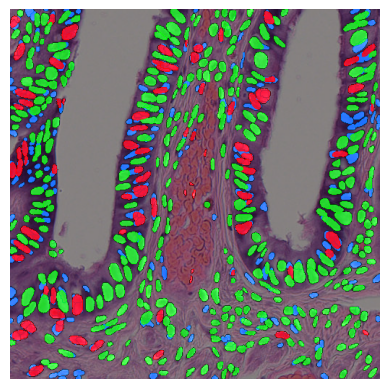

In [53]:
overlays = [make_overlay(img, gts[i], preds[i]) for i, img in tqdm(enumerate(images))]
[io.imsave(os.path.join(output_folder, 'before_' + name), overlays[i]) for i, name in tqdm(enumerate(names))]
print('Before Retraining Overlays Complete')
plt.imshow(overlays[0])
plt.axis('off')
plt.show()

In [58]:
model_path = r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\StarDist Segmentation Models\Models for Collage Retrain\SD_HE_20x -to- FallopianTube"
model = sd.load_model(model_path=model_path)

names, images, gts = [], [], []
img_names = os.listdir(img_folder)
for img_name in img_names:
    if img_name.endswith('.tif') and 'test' in img_name and 'FallopianTube' in img_name:
    # if 'Skin_test_3.tif' in img_name:
        names.append(img_name)
        images.append(io.imread(os.path.join(img_folder, img_name)))
        gts.append(io.imread(os.path.join(gt_folder, img_name)))
preds = [model.predict_instances(img / 255)[0] for img in images]

base_model.py (198): output path for model already exists, files may be overwritten: \\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\StarDist Segmentation Models\Models for Collage Retrain\SD_HE_20x -to- FallopianTube


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.679031, nms_thresh=0.3.
Overriding defaults: Thresholds(prob=0.679031450233438, nms=0.3) 



5it [00:13,  2.77s/it]

After Retraining Overlays Complete


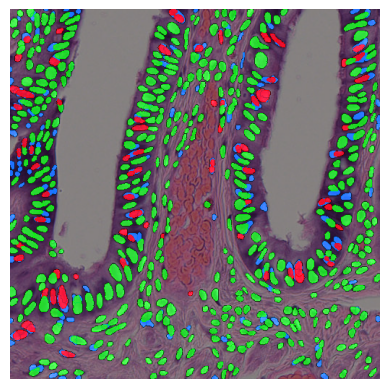

In [59]:
overlays = [make_overlay(img, gts[i], preds[i]) for i, img in tqdm(enumerate(images))]
[io.imsave(os.path.join(output_folder, 'after_' + name), overlays[i]) for i, name in tqdm(enumerate(names))]
print('After Retraining Overlays Complete')
plt.imshow(overlays[0])
plt.axis('off')
plt.show()